In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import math
from scipy.constants import N_A

In [106]:
Target_cell_number = 2e5
well_size = 125e-6
t_end = 60*60*5
t = np.geomspace(1e-10, t_end, 500)
t_span = [1e-10, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
sigma = well_size*N_A/Target_cell_number

In [107]:
def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

def monovalent_binding(t, z, Ainit, rtot, kon, koff):
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z
     Ag = rtot - z

     dA1 = k*Ag*A0/Atot - koff*z

     return dA1

def EC50_finder(array, A0s):
    half_max = 0.5*np.max(array) 
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

In [108]:
def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

def mono_valent_steady_state(Ainit, k1, koff, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    a = 1
    b = -((koff/k1) + rtot + Atot)
    c = rtot*Atot

    st = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

    return st

In [109]:
A0s = np.geomspace(1e-13, 5e-5, 350)

In [110]:
kon_powers = np.linspace(5, 3, 300)
koff_powers = np.linspace(-5, -3, 300)
rtots = np.linspace(3, 6, 300)
kons = 10**kon_powers
koffs = 10**koff_powers
rtots = 10**rtots
D = 1e-13
k2 = 4*D/tumour_cell_surface_area
mono_Ec50s = np.zeros_like(kon_powers)
biv_Ec50s = np.zeros_like(kon_powers)
Y = np.zeros((len(rtots), len(rtots)))
Y1 = np.zeros((len(rtots), len(rtots)))

for k, rtot in enumerate(rtots):
    print(k)
    for i, kon in enumerate(kons):
        bivalent = np.zeros_like(A0s)
        bivalent1 = np.zeros_like(A0s)
        koff = koffs[i]
        for j, Ainit in enumerate(A0s):

            # simulate bivalent binding
    
            A1_st = fsolve(A1_steady_state, [0], args=(Ainit, kon, koff, k2, rtot))
            A2_st = A2_steady_state(A1_st, k2, koff, rtot)
            if (A1_st < 0) or (A2_st < 0) :
                print('negative')
        
            if ((A1_st + 2*A2_st) > rtot):
                print('blown up')

            Ab = A1_st + A2_st
            Ab1 = A1_st + 2*A2_st
            bivalent[j] = Ab
            bivalent1[j] = Ab1

        mono_ec50 = EC50_finder(mono_valent_steady_state(A0s, kon, koff, rtot), A0s)
        biv_Ec50 = EC50_finder(bivalent, A0s)
        biv_Ec501 = EC50_finder(bivalent1, A0s)
        delta_Ec50 = np.log10(mono_ec50) - np.log10(biv_Ec50)
        delta_Ec501 = np.log10(mono_ec50) - np.log10(biv_Ec501)
        if mono_ec50 < biv_Ec501:
            print(mono_ec50, biv_Ec501)
        Y[k, i] = delta_Ec50
        Y1[k, i] = delta_Ec501



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299


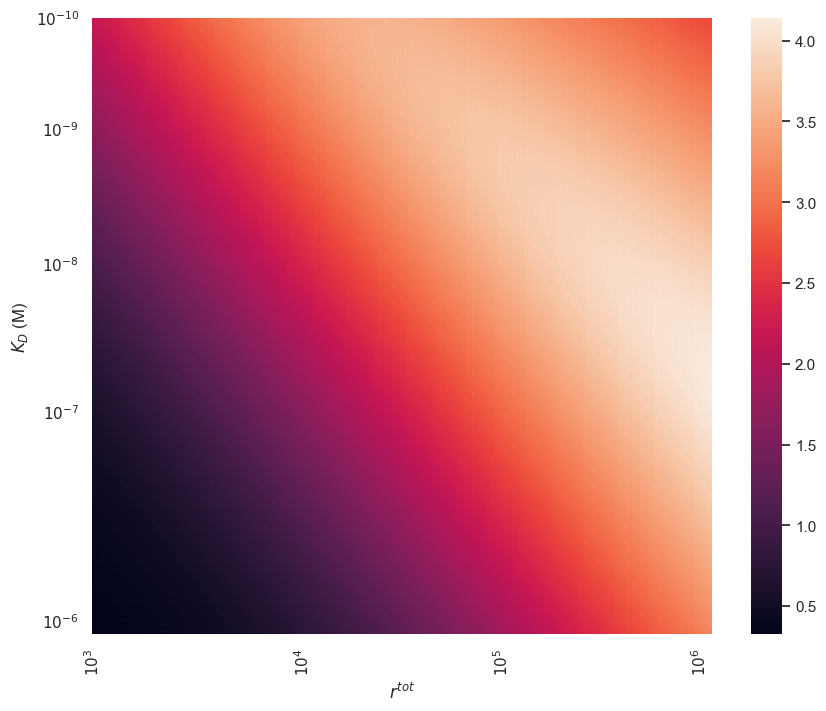

In [115]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 8))
line = sns.heatmap(Y1, xticklabels=True, yticklabels=True, ax=ax) 
ax.set_yticks([0, 9*6, 20*6, 32*6, 49*6])
ax.set_xticks([0, 17*6, 33*6, 49*6])
ax.set_yticklabels([r'$10^{-10}$', r'$10^{-9}$',r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$'])
ax.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'])
ax.set_xlabel(r'$r^{tot}$')
ax.set_ylabel(r'$K_D$ (M)')
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/receptor_occupancy_high_res_delta_ec50_heatmap_D_1e-13.eps')